In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Inner-zonal trips
## Preperation of calibration data
Assignment of inner-zonal trips is not possible in a classic transport model. Trip lengths by mode and purpose must be approximated with MiD2017 data using a logistic regression

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

Inner-cellular mode choice will be dependent on cell-specific network data as well as trip-specific and socio-economic data. All categories must be available in the calibration data set as well as in the model.
* Accessibility by mode in this cell (weighted average, see prep3X)
* Population density (population by km²)
* Road network coverage (length by km²) -- not implemented
* Economic status of household or cell (GDP)
* Car ownership in this cell
* Employed persons in this cell

## Load trips table from MiD and filter

In [18]:
trips = pd.read_csv('../input/transport_demand/MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'wegkm_imp', 'km_routing_gr','wegmin_imp1',
               'hwzweck1', 'hvm_diff2', 'auto', 'W_SO2', 'sieddichte', # alternatively ewqkm
               'bahn28', 'bus28', 'bahn28_zo', 'bus28_zo']]
trips.columns = ['origin', 'destination', 'distance', 'distance_routed', 'duration',
                 'purpose', 'mode', 'car_avail', 'W_SO2', 'pop_density',
                 'dist_train_origin', 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination']
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))
print(trips.shape)

(960619, 14)


In [19]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
print(trips.shape)

(959778, 14)


In [21]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['mode']<24)]
print(trips.shape)

(899571, 14)


<AxesSubplot:title={'center':'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

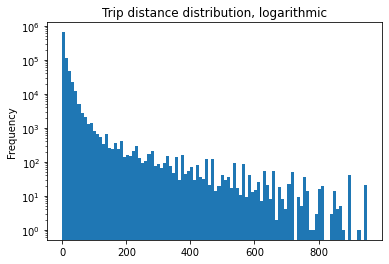

In [24]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True, title='Trip distance distribution, logarithmic')

In [20]:
trips.loc[trips['distance']<=1].shape

(191757, 14)

In [25]:
# Filter for short-distance traffic
trips = trips.loc[~trips['distance_routed'].isin([8,9])]
trips = trips.loc[trips['distance']<=50]
print(trips.shape)

(845530, 14)


<AxesSubplot:title={'center':'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

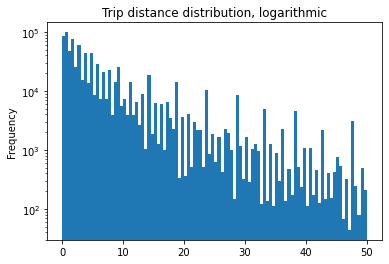

In [26]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True, title='Trip distance distribution, logarithmic')

<AxesSubplot:ylabel='Frequency'>

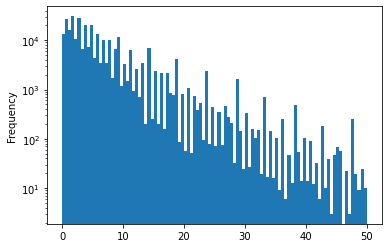

In [27]:
# Compare to trip distance of inner-cell trips
# It should look roughly the same as above with lower total numbers though
trips.loc[(trips['origin']==trips['destination']) &
          (trips['origin']<9999) &
          (trips['destination']<9999), 'distance'].plot.hist(bins=100, log=True)

In [28]:
# Remove ferries
trips = trips.loc[trips['mode']!=19]
print(trips.shape)

(845002, 14)


In [29]:
# Match mode with the model modes
# Non-motorised modes are merged
# See cal10
model_modes = {1: 'rail_short', 2: 'rail_long',
               3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_mid_vp_dict = {1:7, 2:7, 3:7, 4:6, 5:6, 6:6, 7:6, 8:6,
                    9:6, 10:6, 11:6, 12:4, 13:4, 14:4, 15:4,
                    16:1, 17:6, 18:6, 19:6, 20:2, 21:3, 22:3,
                    23:5, 24:7}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

In [30]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
# see cal10
purpose_mid_vp_dict = {1: 1, 2: 4, 3: 2, 4: 3, 5: 3, 6: 6, 7: 6, 99: 6}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

In [31]:
# Convert distances to integer kilometers
dist_dict = {1:1, 2:1, 3:1, 4:2, 5:4, 6:6, 95:20, 701:20}
trips['dist_train_origin'] = trips['dist_train_origin'].map(dist_dict)
trips['dist_bus_origin'] = trips['dist_bus_origin'].map(dist_dict)
trips['dist_train_destination'] = trips['dist_train_destination'].map(dist_dict)
trips['dist_bus_destination'] = trips['dist_bus_destination'].map(dist_dict)

<AxesSubplot:title={'center':'Trip duration distribution, logarithmic'}, ylabel='Frequency'>

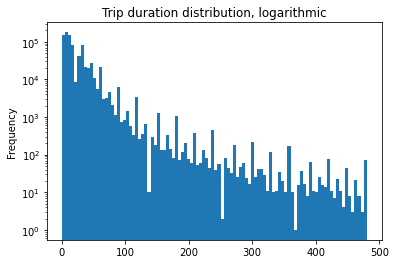

In [32]:
# Trip duration
trips['duration'].plot.hist(bins=100, log=True, title='Trip duration distribution, logarithmic')

<AxesSubplot:title={'center':'share of trips by purpose'}, ylabel='None'>

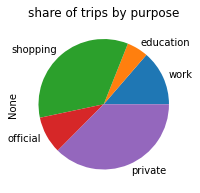

In [33]:
# Trip purpose
trips.groupby('purpose_vp').size().plot.pie(
    subplots=False,figsize=(3, 3),labels=['work', 'education', 'shopping', 'official', 'private'],
    title='share of trips by purpose')

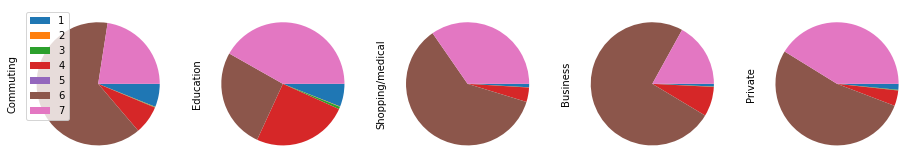

In [34]:
# Modal split
axs = trips.groupby(['mode_model','purpose_vp']).size().unstack(fill_value=0).rename(
    columns={1:'Commuting', 2:'Education', 3:'Shopping/medical', 4:'Business', 6:'Private'}).plot.pie(
    subplots=True, figsize=(16, 4),# labels=trips['mode_model'].map(model_modes),
    startangle=0, counterclock=False,
    legend=False, labeldistance=None)
axs[0].legend()

In [35]:
str(model_modes)

"{1: 'rail_short', 2: 'rail_long', 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}"

In [36]:
# Remove air, rail long and coach because they are long-distance only
trips = trips.loc[(trips['mode_model']!=2) &
                  (trips['mode_model']!=3) &
                  (trips['mode_model']!=5)]
print(trips.shape)

(843582, 16)


## Imputate network data to trips

In [25]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [93]:
# Replace LAU IDs with NUTS IDs in origin and destination
lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
trips['NUTS_ID'] = trips['origin'].astype(str).map(lau_nuts_dict)
# Drop all other trips
trips = trips.loc[trips['NUTS_ID'].notna()]
print(trips.shape)

(298764, 17)


In [94]:
# Number of zones with survey participants
len(trips['NUTS_ID'].unique())

318

### Car ownership
Car ownership from the German federal statistical office GENESIS data base table 46251-0006: "Kraftfahrzeugbestand: Kreise, Stichtag, Kraftfahrzeugarten". Download at Nov. 26th 2020. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [29]:
# Load the table
cars = pd.read_excel(input_path + 'spatial_car_ownership_2017_GENESIS.xlsx')
cars['sum_MIT'] = cars['Krafträder'] + cars['Pkw']
cars['lau_id'] = cars['lau_id'].astype(str)
cars['sum_MIT'] = cars['sum_MIT'].replace({'--': 0}).astype(int)
cars.set_index('lau_id', drop=True, inplace=True)
lau_car_dict = cars['sum_MIT'].to_dict()
sm.zones['car_ownership'] = sm.zones['lau_id'].map(lau_car_dict)
sm.zones.head(2)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry,car_ownership
index,,,,,,,,,,
DE600,DE,Hamburg,3,DE600,1841179,755.09,1.0,2000,"MULTIPOLYGON (((9.94538 53.65293, 9.95059 53.6...",824411
DE711,DE,"Darmstadt, Kreisfreie Stadt",3,DE711,159207,122.07,1.0,6411,"POLYGON ((8.72571 49.95421, 8.73453 49.94858, ...",76945


In [30]:
# Empty rows
print(len(sm.zones.loc[sm.zones['car_ownership'].isna()]))
sm.zones.loc[sm.zones['car_ownership']<sm.zones['population']/3]

0


,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry,car_ownership
index,,,,,,,,,,
DE91C,DE,Göttingen,3,DE91C,328074,1755.39,3.0,3159,"POLYGON ((10.67728 51.63838, 10.67664 51.63294...",0
DEB25,DE,Trier-Saarburg,3,DEB25,148945,1102.22,3.0,7235,"POLYGON ((6.71195 49.90481, 6.72201 49.89223, ...",0


In [31]:
# Car density
sm.zones['car_density'] = sm.zones['car_ownership'] / sm.zones['population']

In [32]:
# Replace empty rows with average density
sm.zones.loc[sm.zones['car_ownership']==0, 'car_density'] = \
    sm.zones['car_density'].replace({0: np.nan}).mean(skipna=True)

In [33]:
# Imputate into trips
zone_dict = sm.zones['car_density'].to_dict()
trips['car_density'] = trips['NUTS_ID'].map(zone_dict)

### Population density

In [89]:
# If not available for this trip, take average from model
print(trips.loc[trips['pop_density']==95].shape)

(27964, 16)


In [90]:
# Population density in the model
sm.zones['pop_density'] = sm.zones['population'] / sm.zones['area']

In [91]:
# Categorise like in MiD2017
bins = [0,100,250,500,1000,2000,5000,10000,100000]
cats = [1,2,3,4,5,6,7,8]
sm.zones['pop_density_cat'] = pd.cut(sm.zones['pop_density'], bins=bins, labels=cats)
zone_dict = sm.zones['pop_density_cat'].to_dict()

In [95]:
trips.loc[trips['pop_density']==95, 'pop_density'] = \
    trips.loc[trips['pop_density']==95, 'NUTS_ID'].map(zone_dict)

<AxesSubplot:>

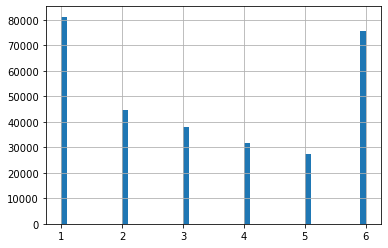

In [96]:
trips['pop_density'].hist(bins=50)

<AxesSubplot:>

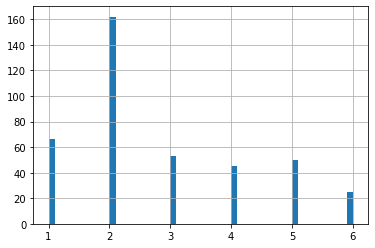

In [68]:
sm.zones['pop_density_cat'].hist(bins=50)

### Accessibility
Enrich trips with the accessibility metric

In [39]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) inverse weight of distances
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [40]:
# The maximum accessibility for foot, bicycle and car is 1
trips['accessibility_walk'] = 1
trips['accessibility_car'] = trips['car_avail'].replace({9:0})

In [41]:
# Rail
trips['accessibility_rail'] = [accessibility(o, d) for o, d in zip(
    trips['dist_train_origin'], trips['dist_train_destination'])]

In [42]:
# Bus
trips['accessibility_bus'] = [accessibility(o, d) for o, d in zip(
    trips['dist_bus_origin'], trips['dist_bus_destination'])]

In [43]:
# Summary
trips.groupby('mode_model').agg(
    {'accessibility_car': 'mean', 'accessibility_rail': 'mean',
     'accessibility_bus': 'mean'})

,accessibility_car,accessibility_rail,accessibility_bus
mode_model,,,
1,0.740227,0.788841,0.827113
4,0.733136,0.729902,0.834290
6,0.989591,0.649981,0.775443


### GDP
Take cell-specific GDP data from eurostat 
https://ec.europa.eu/eurostat/de/web/rural-development/data

In [61]:
pd.read_csv(input_path + 'spatial_employed_persons_2017_eurostat.csv', encoding='latin-1')

,TIME,GEO,UNIT,WSTATUS,NACE_R2,Value,Flag and Footnotes
0,2017,Germany (until 1990 former territory of the FRG),Thousand,Employed persons,Total - all NACE activities,"44,262",p
1,2017,Baden-Württemberg,Thousand,Employed persons,Total - all NACE activities,"6,256.39",p
2,2017,Stuttgart,Thousand,Employed persons,Total - all NACE activities,"2,408.49",p
3,2017,"Stuttgart, Stadtkreis",Thousand,Employed persons,Total - all NACE activities,529.85,p
4,2017,Böblingen,Thousand,Employed persons,Total - all NACE activities,230.09,p
...,...,...,...,...,...,...,...
451,2017,Saale-Orla-Kreis,Thousand,Employed persons,Total - all NACE activities,39.02,p
452,2017,Greiz,Thousand,Employed persons,Total - all NACE activities,39.28,p
453,2017,Altenburger Land,Thousand,Employed persons,Total - all NACE activities,35.72,p
454,2017,"Eisenach, Kreisfreie Stadt",Thousand,Employed persons,Total - all NACE activities,28.5,p


In [59]:
gdp = pd.read_csv(input_path + 'spatial_GDP_2017_eurostat.csv', encoding='latin-1')
gdp['Value'] = gdp['Value'].str.replace(',', '').astype(float)

In [64]:
# Assign GDP to zones
gdp_dict = gdp.loc[gdp['UNIT']=='Euro per inhabitant'].set_index('GEO')['Value'].to_dict()
sm.zones['gdp_pc'] = sm.zones['NUTS_NAME'].map(gdp_dict)

In [65]:
sm.zones.loc[sm.zones['gdp_pc'].isna(), 'gdp_pc'] = \
    sm.zones.loc[sm.zones['gdp_pc'].notna(), 'gdp_pc'].mean()

In [66]:
sm.zones['gdp_pc'] = sm.zones['gdp_pc'].astype(int)

In [67]:
sm.zones.loc[sm.zones['gdp_pc'].isna()]

,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry,car_ownership,car_density,pop_density,pop_density_cat,gdp_pc
index,,,,,,,,,,,,,,


## Save dataset

In [71]:
trips.to_csv('../input/transport_demand/calibration_intra-cellular_trips_MiD2017.csv')